# Cart Pole Agent

### Reinforcment Learning using PyTorch Deep Q-Network Model


Michele Ventimiglia - All rights are reserved

## Initialization

### Libraries

In [1]:
import os
import sys
import time
import torch
import random
import torchinfo
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch.nn.functional as F
from itertools import count
from datetime import datetime
from collections import deque
from torch.optim import Adam, Optimizer
from torch.nn import Module, Linear, MSELoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import Tensor, FloatTensor, LongTensor, cuda
from typing import Optional, Tuple, List, Union, Deque, Type

Get info about Python and the main packages.

In [2]:
print(f"[i] Python v{sys.version}")
print(f"[i] PyTorch v{torch.__version__}")  # Framework
print(f"[i] NumPy v{np.__version__}")
print(f"[i] Gymnasium v{gym.__version__}")  # Environment Simulator

[i] Python v3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]
[i] PyTorch v2.1.0.dev20230817+cu121
[i] NumPy v1.25.2
[i] Gymnasium v0.29.1


### Game Environment Setup

In [3]:
show = True
env = gym.make(id='CartPole-v1') if not show else gym.make(id='CartPole-v1', render_mode="human")
print(f"[i] Environment output shape: {env.observation_space.shape[0]}")
print(f"[i] Environment input shape: {env.action_space.n}")
print(f"[i] Display training: {show}")

[i] Environment output shape: 4
[i] Environment input shape: 2
[i] Display training: True


### Cuda Setup

In [4]:
device = torch.device('cpu')

if cuda.is_available():
    if not cuda.is_initialized():
        cuda.init()
    num_gpus = cuda.device_count()
    if num_gpus > 1:
        print(f"[i] {num_gpus} GPUs detected. Using DataParallel.")
        device = [torch.device(f"cuda:{i}") for i in range(num_gpus)]
    else:
        print("[i] 1 GPU detected.")
        device = torch.device("cuda:0")
    for i in range(num_gpus):
        print(f"[i] GPU {i}: {cuda.get_device_name(i)}")
    cuda.empty_cache()
else:
    print("[!] CUDA unavailable")
print(f"[i] Using device(s): {device}")

[i] 1 GPU detected.
[i] GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU
[i] Using device(s): cuda:0


## Deep Q-Network

### Model Architecture

In [5]:
class DQN(Module):
    def __init__(
            self,
            input_dim: int, 
            output_dim: int,
            verbose: bool = True
        ) -> None:
        super().__init__()
        
        # input dimension
        self.input_dim = input_dim
        
        # output dimension
        self.output_dim = output_dim
        
        # dense layer 1
        self.fc1 = Linear(input_dim, 128)
        
        # dense layer 2 
        self.fc2 = Linear(128, 128)
        
        # dense layer 3
        self.fc3 = Linear(128, output_dim)
        
        # display moodel summary
        if verbose: self.summary()
    
    def forward(
            self,
            x: Tensor
        ) -> Tensor:
        
        # activation function 1
        x = F.leaky_relu(self.fc1(x)) 
        
        # activation function 2 
        x = F.leaky_relu(self.fc2(x))
        
        return self.fc3(x)
    
    def summary(self) -> None:
        torchinfo.summary(
            model = self.to('cuda' if torch.cuda.is_available() else 'cpu'),
            input_size = (self.input_dim,),
            verbose = True
        )

### Agent

In [6]:
class Agent:
    def __init__(
            self,
            input_dim: int,
            output_dim: int,
            memory_size: int,
            epsilon_start: float,
            learning_rate: float,
            device: torch.device = 'cpu',
            optimizer: Type[Optimizer] = Adam,
            loss: Module = MSELoss(),
            verbose: bool = True,
        ) -> None:
        self.device = device
        
        # model initialization
        self.q_network = DQN(input_dim, output_dim, verbose).float().to(self.device)
        self.optimizer = optimizer(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = loss
        
        self.memory: Deque[Tuple[Union[np.ndarray, List[float]], int, float, Union[np.ndarray, List[float]], bool]] = deque(maxlen=memory_size)
        self.epsilon = epsilon_start
    
    def to(
            self,
            device: torch.device
        ) -> None:
        self.device = device

    def choose_action(
            self,
            state: Union[np.ndarray, List[float]]
        ) -> int:
        # decide whether to take a random action based on epsilon
        if random.random() < self.epsilon:
            return random.choice([0, 1])
        else:
            # predict the Q-values for the state and choose the action with the highest Q-value
            with torch.no_grad():
                return torch.argmax(self.q_network(FloatTensor(state).to(self.device))).item()

    def store_transition(
            self,
            state: Union[np.ndarray, List[float]],
            action: int,
            reward: float,
            next_state: Union[np.ndarray, List[float]],
            done: bool
        ) -> None:
        self.memory.append((state, action, reward, next_state, done))

    def train(
            self,
            batch_size: int,
            gamma: float,
            epsilon_end: float,
            epsilon_decay: float
        ) -> None:
        if len(self.memory) < batch_size:
            return
        
        # sample a random batch of experiences from memory and unpack it
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = FloatTensor(np.array(states)).to(self.device)
        actions = LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = FloatTensor(np.array(next_states)).to(self.device)
        dones = FloatTensor(dones).unsqueeze(1).to(self.device)

        # calculate the current Q-values
        current_q_values = self.q_network(states).gather(1, actions)
        # calculate the Q-values for the next states
        next_q_values = self.q_network(next_states).max(1)[0].unsqueeze(1)
        # calculate the target Q-values using the Bellman equation
        target_q_values = rewards + (1 - dones) * gamma * next_q_values

        # compute the loss and zero the gradients
        loss = self.loss_fn(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        
        # backpropagate the loss and update the weights
        loss.backward()
        self.optimizer.step()

        # decay the exploration rate
        self.epsilon = max(epsilon_end, epsilon_decay * self.epsilon)


## Training

### Early Stopping

In [7]:
class EarlyStopping:
    def __init__(
            self,
            patience: int = 5,  # number of epochs with no improvement after which training will be stopped
            min_delta: float = 0.01,  # minimum change in the monitored parameter to qualify as an improvement
            mode: str = 'min',   # mode for determining when an improvement occurred ('min' or 'max')
            save_folder: str = './',
            verbose: bool = True
        ) -> None:
        assert mode in ['min', 'max'], "Mode must be either 'min' or 'max'"
        self.save_folder = save_folder
        self.patience = patience 
        self.min_delta = min_delta
        self.mode = mode
        self.best_batch_param = np.inf if mode == 'min' else -np.inf
        self.best_param = np.inf if mode == 'min' else -np.inf
        self.best_epoch_overall: Optional[int] = None
        self.counter = 0
        self.best_epoch_batch: Optional[int] = None
        self.verbose = verbose

    def get_checkpoint_path(self) -> str:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        save_path = os.path.join(self.save_folder, f'checkpoint_{timestamp}.pth')
        return save_path

    def check_improvement(
            self,
            parameter: float,
            best_param: float
        ) -> bool:
        if self.mode == 'min':
            return parameter < best_param - self.min_delta
        else:
            return parameter > best_param + self.min_delta

    def check_batch(
            self,
            parameter: float,
            epoch: int,
            model: Module,
            optimizer: Optimizer,
        ) -> bool:
        # save a checkpoint (model and optimizer current state)
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_param': self.best_param
        }
        torch.save(checkpoint, self.get_checkpoint_path())

        # check if the current parameter is an improvement for the batch
        if self.check_improvement(parameter, self.best_batch_param):
            self.best_batch_param = parameter
            self.best_epoch_batch = epoch
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"[!] No improvement in the last batch: [{self.counter}/{self.patience}]")
            if self.counter >= self.patience:
                if self.verbose:
                    print(f"[!] Early stopping triggered at epoch {epoch+1}.")
                return True
        return False

    def check_episode(
            self,
            parameter: float,
            epoch: int,
            model: Module,
            optimizer: Optimizer
        ) -> bool:
        # check if the current parameter is an overall improvement
        if self.check_improvement(parameter, self.best_param):
            self.best_param = parameter
            self.best_epoch_overall = epoch
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_param': self.best_param
            }
            
            # save the best state of the model
            torch.save(checkpoint, os.path.join(self.save_folder, 'best_weights.pth'))
            return True
        return False

    def __call__(
            self,
            parameter: float,
            epoch: int,
            model: Module,
            optimizer: Optimizer,
            batch: bool = False
        ) -> bool:
        if batch:
            return self.check_batch(parameter, epoch, model, optimizer)
        else:
            return self.check_episode(parameter, epoch, model, optimizer)

    def restore(
            self,
            model: Module,
            optimizer: Optional[Optimizer] = None
        ) -> Tuple[Module, Optional[Optimizer], Optional[int], Optional[int]]:
        checkpoint = torch.load(os.path.join(self.save_folder, 'best_weights.pth'))
        model.load_state_dict(checkpoint['model_state_dict'])
        
        if optimizer:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_param = checkpoint['best_param']
        
        if self.verbose:
            print(f"[i] Model restored to the best state from epoch {self.best_epoch_overall-1}.")
            
        return model, optimizer, self.best_epoch_overall, best_param

### Hyperparameters

In [8]:
GAMMA: float = 0.99
EPSILON_START: float = 1.0
EPSILON_END: float = 0.01
EPSILON_DECAY: float = 0.995
LEARNING_RATE: float = 0.001
BATCH_SIZE: int = 64
MEMORY_SIZE: int = 10000
CHECKPOINT_FOLDER: os.PathLike = "./checkpoints/"
optimizer: Type[Optimizer] = Adam
loss = MSELoss()

We create classes for the Agent, the Early Stopping and the Learning Rate Scheduler:

In [9]:
agent = Agent(
    input_dim = env.observation_space.shape[0],
    output_dim = env.action_space.n,
    memory_size = MEMORY_SIZE,
    epsilon_start = EPSILON_START,
    learning_rate = LEARNING_RATE,
    optimizer = optimizer,
    loss = loss,
    device = device,
    verbose = True
)

Layer (type:depth-idx)                   Output Shape              Param #
DQN                                      [2]                       --
├─Linear: 1-1                            [128]                     640
├─Linear: 1-2                            [128]                     16,512
├─Linear: 1-3                            [2]                       258
Total params: 17,410
Trainable params: 17,410
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.20
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07


In [10]:
early_stopping = EarlyStopping(
    patience = 3,
    min_delta = 0,
    mode = 'max',
    save_folder = CHECKPOINT_FOLDER,
    verbose = True
)

In [11]:
lr_scheduler = ReduceLROnPlateau(
    agent.optimizer,
    mode = 'min',
    factor = 0.5,
    patience = 3,
    verbose = True
)

We define a function to format the time that will be displayed:

In [12]:
def format_time(seconds_elapsed):
    hours, remainder = divmod(seconds_elapsed, 3600)
    minutes, seconds = divmod(remainder, 60)
    milliseconds = int((seconds_elapsed % 1) * 1000)
    return f"{int(hours)}h-{int(minutes)}m-{int(seconds)}s-{milliseconds:03}ms"

### Training Loop

In [13]:
EPISODES_BATCH = 10  # number of episodes to group together for batch processing and evaluation (without too many fluctuations)

history = []
avg_rewards = []

print(f"[i] Training on {device}...")

start_time = time.time()

try:  # handles interruptions
    # main training loop, iterating over episodes
    for _, episode in enumerate(count(start=1)):
        if episode % EPISODES_BATCH == 1:
            batch_start_time = time.time()

        episode_start_time = time.time()

        # reset the environment and initialize variables for the episode
        state, _ = env.reset()
        episode_reward = 0
        done = False

        # episode loop
        while not done:
            action = agent.choose_action(state)  # select an ation
            next_state, reward, done, _, _ = env.step(action)  # execute the action
            agent.store_transition(state, action, reward, next_state, done)  # save in memory
            agent.train(BATCH_SIZE, GAMMA, EPSILON_END, EPSILON_DECAY)  # train the agent
            episode_reward += reward  # get the reward
            state = next_state  # update the state
        
        # Store the episode's reward and compute the average reward over the last ten episodes
        history.append(episode_reward)
        avg_rewards.append(np.mean(history[-EPISODES_BATCH:]))
        
        # check for early stopping based on the reward of the current episode
        early_stopping(episode_reward, episode, agent.q_network, agent.optimizer)

        # print info about the training
        progress = int((episode % EPISODES_BATCH) / EPISODES_BATCH * 10)
        progress_bar = "="*progress + ">" + "."*(10-progress)
        avg_reward = np.average(history[-10:])
        elapsed_time = format_time(time.time() - start_time)
        episode_time = format_time(time.time() - episode_start_time)
        print(f"[{progress_bar}] Episode: {episode}  - Reward: {int(episode_reward)} - Episode Time: {episode_time} {' '*10}", end='\r')
        
        if episode % EPISODES_BATCH == 0:
            batch_time = format_time(time.time() - batch_start_time)
            print(f"Episodes: [{episode-EPISODES_BATCH}-{episode}] - Avg Reward: {int(avg_reward)} - Max Reward: {int(np.max(history))} - Batch Time: {batch_time} {' '*10}")
            
            # check for early stopping based on the average reward of the batch of episodes
            if early_stopping(avg_reward, episode, agent.q_network, agent.optimizer, batch=True):
                break
                
            # adjust the learning rate based on the recent performance
            lr_scheduler.step(-avg_rewards[-1])

except KeyboardInterrupt:  # allow for manual interruption of the training loop
    print("\n[i] Training interrupted by user.")

finally:
    # close the environment if it was being displayed
    if show: 
        env.close()

    # restore the best model and optimizer states from the training
    agent.q_network, agent.optimizer, best_epoch, best_score = early_stopping.restore(agent.q_network, agent.optimizer)

    total_elapsed_time = format_time(time.time() - start_time)
    print(f"[i] Training complete. Total Elapsed Time: {total_elapsed_time}")

[i] Training on cuda:0...
Episodes: [0-10] - Avg Reward: 28 - Max Reward: 68 - Batch Time: 0h-0m-6s-943ms           
Episodes: [10-20] - Avg Reward: 46 - Max Reward: 68 - Batch Time: 0h-0m-9s-784ms           
Episodes: [20-30] - Avg Reward: 83 - Max Reward: 124 - Batch Time: 0h-0m-17s-426ms           
Episodes: [30-40] - Avg Reward: 144 - Max Reward: 293 - Batch Time: 0h-0m-29s-841ms           
Episodes: [40-50] - Avg Reward: 171 - Max Reward: 293 - Batch Time: 0h-0m-35s-389ms           
Episodes: [50-60] - Avg Reward: 147 - Max Reward: 293 - Batch Time: 0h-0m-30s-606ms           
[!] No improvement in the last batch: [1/3]
Episodes: [60-70] - Avg Reward: 202 - Max Reward: 293 - Batch Time: 0h-0m-41s-837ms           
Episodes: [70-80] - Avg Reward: 173 - Max Reward: 293 - Batch Time: 0h-0m-35s-812ms           
[!] No improvement in the last batch: [1/3]
Episodes: [80-90] - Avg Reward: 201 - Max Reward: 293 - Batch Time: 0h-0m-41s-574ms           
[!] No improvement in the last batch: [

## Model Evalutation

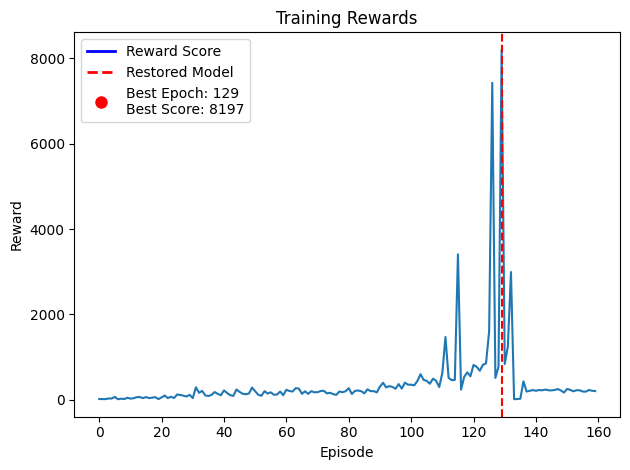

In [14]:
plt.plot(history, label="Reward Score")

plt.axvline(
    best_epoch-1,
    label='Restored model weights',
    color='red',
    linestyle='--'
)

# Create custom legend entries
legend_elements = [
    plt.Line2D(
        [0], [0],
        color = 'blue',
        lw = 2,
        label = "Reward Score"
    ),
    plt.Line2D(
        [0], [0],
        color = 'red',
        linestyle = '--',
        lw = 2,
        label=  'Restored Model'
    ),
    plt.Line2D(
        [0], [0],
        marker = 'o',
        color = 'w',
        markerfacecolor = 'red',
        markersize = 10,
        label = f'Best Epoch: {best_epoch-1}\nBest Score: {int(best_score)}'
    )
]

plt.legend(handles=legend_elements, loc='upper left')

plt.title("Training Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.tight_layout()
plt.show()

## Model Testing

We load the best optimizer and the best model weights: 

In [15]:
checkpoint = torch.load(os.path.join(CHECKPOINT_FOLDER, "best_weights.pth"))
agent.q_network.load_state_dict(checkpoint['model_state_dict'])
agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"[i] Loaded checkpoint at epoch {checkpoint['epoch']-1} with best reward of {int(checkpoint['best_param'])}.")

[i] Loaded checkpoint at epoch 129 with best reward of 8197.


### Game Simulation

In [16]:
env = gym.make('CartPole-v1', render_mode="human")

print(f"[i] Testing on {device}...")

try:
    for episode in count(start=1):
        start_time = time.time()
        
        state, _ = env.reset()
        done = False
        
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            state = next_state
            
            test_time = format_time(time.time() - start_time)
            print(f"Elapsed Time: {test_time}", end='\r')
            
except KeyboardInterrupt:
    print("[!] Testing interrupted by user.")

finally:
    env.close()
    
    total_elapsed_time = format_time(time.time() - start_time)
    print(f"[i] Testing terminated. Total Elapsed Time: {total_elapsed_time}")

[i] Testing on cuda:0...
[!] Testing interrupted by user.
[i] Testing terminated. Total Elapsed Time: 0h-31m-53s-005ms
